In [1]:
# @Time     : Jan. 13, 2019 20:16
# @Author   : Veritas YIN
# @FileName : trainer.py
# @Version  : 1.0
# @IDE      : PyCharm
# @Github   : https://github.com/VeritasYin/Project_Orion

from data_loader.data_utils import gen_batch
from models.tester import model_inference
from models.base_model import build_model, model_save
from os.path import join as pjoin

import tensorflow as tf
import numpy as np
import time

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

import pandas as pd

# from ws.apis import *
# from ws.shared.read_cfg import *
# from ws.shared.logger import *

def model_train_v2(inputs, blocks, args, Ks_dict, ordering, output_filepath):

    print("Output is saved at..", output_filepath)
    sum_path = pjoin(output_filepath, 'tensorboard')
    perf_log = pd.DataFrame(columns=("epoch", "forecasting_horizon",
                                     "validation_mape", "validation_mae", "validation_rmse",
                                     "test_mape", "test_mae", "test_rmse"))
    row = 0.0

    n, n_his, n_pred = args.n_route, args.n_his, args.n_pred
    Kt = args.kt

    batch_size, epoch, inf_mode, opt = args.batch_size, args.epoch, args.inf_mode, args.opt

    # Placeholder for model training
    x = tf.placeholder(tf.float32, [None, n_his + 1, n, 1], name='data_input')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')

    # Define model loss
    train_loss, pred = build_model(x, n_his, Ks_dict, ordering,
                                   Kt, blocks, keep_prob, batch_size, [args.spat_layernorm, args.temp_layernorm, args.out_layernorm])
    tf.summary.scalar('train_loss', train_loss)
    copy_loss = tf.add_n(tf.get_collection('copy_loss'))
    tf.summary.scalar('copy_loss', copy_loss)

    # Learning rate settings
    global_steps = tf.Variable(0, trainable=False)
    len_train = inputs.get_len('train')
    if len_train % batch_size == 0:
        epoch_step = len_train / batch_size
    else:
        epoch_step = int(len_train / batch_size) + 1
    # Learning rate decay with rate 0.7 every 5 epochs.
    lr = tf.train.exponential_decay(args.lr, global_steps, decay_steps=5 * epoch_step, decay_rate=0.7, staircase=True)
    tf.summary.scalar('learning_rate', lr)
    step_op = tf.assign_add(global_steps, 1)
    with tf.control_dependencies([step_op]):
        if opt == 'RMSProp':
            train_op = tf.train.RMSPropOptimizer(lr).minimize(train_loss)
        elif opt == 'ADAM':
            train_op = tf.train.AdamOptimizer(lr).minimize(train_loss)
        else:
            raise ValueError('ERROR: optimizer "{}" is not defined.'.format(opt))

    merged = tf.summary.merge_all()

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    # config.gpu_options.per_process_gpu_memory_fraction = 0.5
    with tf.Session(config=config) as sess:
        writer = tf.summary.FileWriter(pjoin(sum_path, 'train'), sess.graph)
        sess.run(tf.global_variables_initializer())

        if inf_mode == 'sep':
            # for inference mode 'sep', the type of step index is int.
            step_idx = n_pred - 1
            tmp_idx = [step_idx]
            min_val = min_va_val = np.array([4e1, 1e5, 1e5])
        elif inf_mode == 'merge':
            # for inference mode 'merge', the type of step index is np.ndarray.
            step_idx = tmp_idx = np.arange(3, n_pred + 1, 3) - 1
            min_val = min_va_val = np.array([4e1, 1e5, 1e5] * len(step_idx))
        else:
            raise ValueError("ERROR: test mode {} is not defined.".format(inf_mode))

        start_time = time.time()
        for i in range(epoch):
            start_time_ep = time.time()
            for j, x_batch in enumerate(
                    gen_batch(inputs.get_data('train'), batch_size, dynamic_batch=True, shuffle=True)):
                summary, _ = sess.run([merged, train_op], feed_dict={x: x_batch[:, 0:n_his + 1, :, :], keep_prob: 1.0})
                writer.add_summary(summary, i * epoch_step + j)

                loss_value = sess.run([train_loss, copy_loss], feed_dict={x: x_batch[:, 0:n_his + 1, :, :], keep_prob: 1.0})
                if j % 50 == 0:
                    print('Epoch %.2d, Step %.3d: [%.3f, %.3f]' % (i, j, loss_value[0], loss_value[1]))
            print('Epoch %2d Training Time %.3fs' % (i, time.time() - start_time_ep))

            if i % 10 == 0:
                start_time = time.time()
                min_va_val, min_val = \
                    model_inference(sess, pred, inputs, batch_size, n_his, n_pred, step_idx, min_va_val, min_val)


                print("=======================================================================")
                for ix in tmp_idx:
                    va, te = min_va_val[ix - 2:ix + 1], min_val[ix - 2:ix + 1]
                    print('Time Step %i: MAPE: %.3f, %.3f; MAE:  %.3f, %.3f; RMSE: %.3f, %.3f.' %(ix+1, va[0], te[0], va[1], te[1], va[2], te[2]))
                    perf_log.loc[row] = [i, ix+1, va[0], va[1], va[2], te[0], te[1], te[2]]
                    row += 1
                perf_log.to_csv(pjoin(output_filepath, "perf_log.csv"))

                print('Epoch %2d Inference Time %.3f secs' %(i, time.time() - start_time))
                print("=======================================================================")

            if (i + 1) % args.save == 0:
                print(output_filepath)
                model_save(sess, global_steps, 'STGCN', output_filepath)

        writer.close()

    print('Training model finished!')

/home/rodr/code/env_oldtf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rodr/code/env_oldtf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rodr/code/env_oldtf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rodr/code/env_oldtf/lib/python3.7/site-packages/tensorflow/python/f

In [2]:
# @Time     : Jan. 02, 2019 22:17
# @Author   : Veritas YIN
# @FileName : main.py
# @Version  : 1.0
# @Project  : Orion
# @IDE      : PyCharm
# @Github   : https://github.com/VeritasYin/Project_Orion

import os
from os.path import join as pjoin

import tensorflow as tf
from utils.math_graph import *
from data_loader.data_utils import *
from models.trainer import model_train
from models.tester import model_test

import json
import argparse

n_trial = 1

gpu_id = 0
model_filename = 'model-Urban1.json'
with open(model_filename, 'r') as f:
    model_json = json.load(f)

progress = 0
for key in sorted(model_json.keys()):
    progress += 1
    print("######################## PROGRESS: {} / {} ########################".format(progress, len(model_json)))
    for trial_no in range(n_trial):
        parser = argparse.ArgumentParser()
        ## fixed ##
        parser.add_argument("--n_his", type=int, default=12)
        parser.add_argument("--n_pred", type=int, default=12)
        parser.add_argument("--batch_size", type=int, default=25)
        parser.add_argument("--epoch", type=int, default=100)
        parser.add_argument("--save", type=int, default=50)
        parser.add_argument("--lr", type=float, default=1e-3)
        parser.add_argument("--opt", type=str, default="RMSProp")
        parser.add_argument("--graph", type=str, default="default")
        parser.add_argument("--inf_mode", type=str, default="merge")
        parser.add_argument("--sigma", type=float, default=1e06)
        parser.add_argument("--epsilon", type=float, default=0)
        parser.add_argument("--spat_layernorm", type=bool, default=True)
        parser.add_argument("--temp_layernorm", type=bool, default=True)
        parser.add_argument("--out_layernorm", type=bool, default=True)
        parser.add_argument("-f", type=str, default="")

        parser.set_defaults(**model_json[key])

        args = parser.parse_args()
        output_filepath = os.path.join("./output", args.output_filepath, "trial_%i" %trial_no)
        print(output_filepath)
        print("Training configs: {}".format(args))

        n, n_his, n_pred = args.n_route, args.n_his, args.n_pred
        blocks = args.blocks

        # Partition filters applied
        print("args.data_type:", args.data_type)
        def addKernels(flist, kernel_name, return_itself=[]):
            distance = weight_matrix(pjoin("./dataset", "distance_W_{}.csv".format(args.data_type)),
                                     sigma=args.sigma, epsilon=args.epsilon)
            Lk = []
            for d in flist:
                if d in return_itself:
                    W = distance
                    print("%s is returned itself!" % (d))
                else:
                    mask = pd.read_csv(pjoin("./dataset", d), header=None).values
                    assert np.sum(mask == distance) < (args.n_route * args.n_route), "Distance should be returned itself!"
                    W = np.multiply(mask, distance)
                Lk.append(first_approx(W, n, symmetric=False))

            Lk = np.array(Lk).transpose((1, 2, 0)).reshape([n, n * len(flist)])
            tf.add_to_collection(name=kernel_name, value=tf.cast(tf.constant(Lk), tf.float32))
            print("{} ADDED.".format(kernel_name))

        os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
        os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)

        for k in args.Ks_dict:
            if k in ["distance_kernel", "distance"]: # return distance itself (without partition filters)
                distance = weight_matrix(pjoin("./dataset", "distance_W_{}.csv".format(args.data_type)),
                                         sigma=args.sigma, epsilon=args.epsilon)
                if len(args.Ks_dict[k]["files"]) < args.Ks_dict[k]["n"]:
                    W = scaled_laplacian(distance)
                    Lk = cheb_poly_approx(W, args.Ks_dict[k]["n"], n)
                else:
                    Lk = first_approx(distance, n, symmetric=False)
                tf.add_to_collection(name=k, value=tf.cast(tf.constant(Lk), tf.float32))
                print("{} ADDED.".format(k))

            else:
                addKernels(flist=args.Ks_dict[k]["files"], kernel_name=k,
                           return_itself=["distance_W_{}.csv".format(args.data_type),
                                          "identity_{}.csv".format(args.data_type)])

        dataset = data_gen_ha(args.data_type, forecasting_horizon=args.n_pred, seq_len=args.n_his)
        print(">> Loading dataset with Mean: %.2f, STD: %.2f" % (dataset.mean, dataset.std))

        if not os.path.exists(os.path.join(output_filepath, "performance_test.json")):
            model_train_v2(dataset, blocks, args, args.Ks_dict, args.ordering, output_filepath)

        if not os.path.exists(os.path.join(output_filepath, "models", "predictions.npy")):
            model_test(dataset, 50, n_his, n_pred, output_filepath)

        tf.reset_default_graph()

######################## PROGRESS: 1 / 3 ########################
./output/Urban1-single/trial_0
Training configs: Namespace(Ks_dict={'distance_kernel': {'n': 1, 'files': ['distance_W_Urban1.csv']}}, batch_size=25, blocks=[[1, 32, 64], [64, 32, 64]], data_type='Urban1', epoch=100, epsilon=0, f='/home/rodr/.local/share/jupyter/runtime/kernel-d1f2968e-501e-46cb-80fb-146f12a01b4d.json', graph='default', inf_mode='merge', kt=3, lr=0.001, n_his=12, n_pred=12, n_route=480, opt='RMSProp', ordering=['distance_kernel'], out_layernorm=True, output_filepath='Urban1-single/', save=50, sigma=1000000.0, spat_layernorm=True, temp_layernorm=True)
args.data_type: Urban1
distance_kernel ADDED.
(8640, 480, 1)
(8640, 480, 1)
(8640, 480)
DEBUG: 26.333079523641626
(8640, 480)
>> Loading dataset with Mean: 0.00, STD: 1.00
######################## PROGRESS: 2 / 3 ########################
./output/Urban1-parallel/trial_0
Training configs: Namespace(Ks_dict={'parallel_kernel': {'n': 12, 'files': ['distance_W_Ur

In [3]:
import pandas as pd
speed1 = pd.read_hdf("/home/rodr/code/mobility-baselines/DDP-GCN-main/dataset/spd_5min.h5")
speed = pd.read_csv("dataset/Urban1_V_480.csv", header=None)
speed.index = speed1.index
speed.values.shape

(8640, 480)

In [4]:
# compute historical averages only for train data
(train_time, val_time, test_time) = datasetIdx()
xtimes = np.array([str(t) for t in speed.index])
speed_sum = np.zeros((len(speed.columns),5,12*24))
speed_sum_sq = np.zeros((len(speed.columns),5,12*24))
counts = np.zeros((len(speed.columns),5,12*24))
for dt in train_time:
    weekday = dt.weekday()
    tod = int(dt.hour*12+dt.minute/5)
    tidx = np.where(xtimes == str(dt))[0]
    speed_sum[:,weekday,tod] += speed.iloc[tidx].values[0]
    speed_sum_sq[:,weekday,tod] += (speed.iloc[tidx].values[0]**2)
    counts[:,weekday,tod] += 1.0
    
historical_avg = speed_sum / counts
historical_std = np.sqrt((speed_sum_sq / counts) - (historical_avg**2) + 0.1)

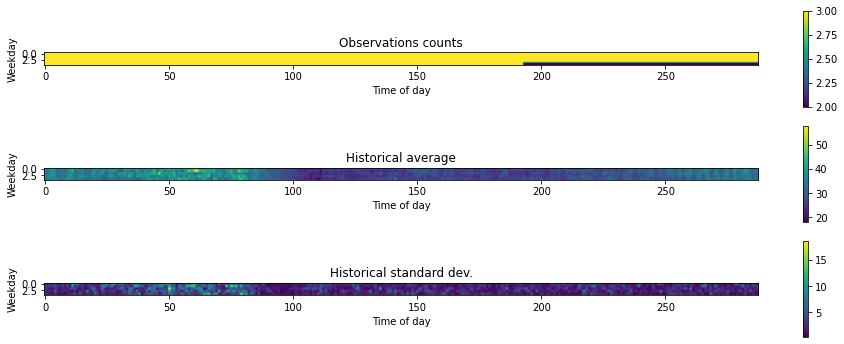

In [5]:
from matplotlib import pyplot as plt
loc = 0
fig, axs = plt.subplots(3, figsize=(16,6))
img = axs[0].imshow(counts[loc,:,:])
axs[0].set_title("Observations counts")
axs[0].set_xlabel("Time of day")
axs[0].set_ylabel("Weekday")
plt.colorbar(img, ax=axs[0])
img = axs[1].imshow(historical_avg[loc,:,:])
axs[1].set_title("Historical average")
axs[1].set_xlabel("Time of day")
axs[1].set_ylabel("Weekday")
plt.colorbar(img, ax=axs[1])
img = axs[2].imshow(historical_std[loc,:,:])
axs[2].set_title("Historical standard dev.")
axs[2].set_xlabel("Time of day")
axs[2].set_ylabel("Weekday")
plt.colorbar(img, ax=axs[2])
plt.show()

In [6]:
# compute residuals of historical averages
trues = []
preds = []
for dt in train_time:
    weekday = dt.weekday()
    tod = int(dt.hour*12+dt.minute/5)
    tidx = np.where(xtimes == str(dt))[0]
    preds.append(historical_avg[:,weekday,tod])
    trues.append(speed.iloc[tidx].values[0])
    
trues = np.expand_dims(np.array(trues), -1)
print(trues.shape)
preds = np.expand_dims(np.array(preds), -1)
print(preds.shape)

from utils.math_utils import evaluation
evl_train = evaluation(trues, preds, {"mean": 0, "std": 1})
print('Trainset Residuals -> MAPE: %.3f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_train)) 

(4225, 480, 1)
(4225, 480, 1)
Trainset Residuals -> MAPE: 0.096; MAE:  2.187; RMSE: 3.277


In [7]:
# compute predictions based on historical averages for train/val/test datasets
train_hist_avg = []
for dt in train_time:
    weekday = dt.weekday()
    tod = int(dt.hour*12+dt.minute/5)
    train_hist_avg.append(historical_avg[:,weekday,tod])
    
train_hist_avg = np.array(train_hist_avg)
print(train_hist_avg.shape)

val_hist_avg = []
for dt in val_time:
    weekday = dt.weekday()
    tod = int(dt.hour*12+dt.minute/5)
    val_hist_avg.append(historical_avg[:,weekday,tod])
    
val_hist_avg = np.array(val_hist_avg)
print(val_hist_avg.shape)

test_hist_avg = []
for dt in test_time:
    weekday = dt.weekday()
    tod = int(dt.hour*12+dt.minute/5)
    test_hist_avg.append(historical_avg[:,weekday,tod])
    
test_hist_avg = np.array(test_hist_avg)
print(test_hist_avg.shape)

(4225, 480)
(580, 480)
(1183, 480)


In [8]:
from utils.math_utils import evaluation, z_inverse
n_his = 12
n_pred = 12
step_idx = 11
x_train, x_val, x_test, x_stats = dataset.get_data('train'), dataset.get_data('val'), dataset.get_data('test'), dataset.get_stats()
print(x_train.shape)

preds_val_ha = val_hist_avg[:,:,np.newaxis]
trues_val = x_val[:, step_idx + n_his, :, :] + preds_val_ha
evl_val = evaluation(trues_val, preds_val_ha, {"mean": 0, "std": 1})
print('Validation set -> MAPE: %.3f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_val)) 

preds_test_ha = test_hist_avg[:,:,np.newaxis]
trues_test = x_test[:, step_idx + n_his, :, :] + preds_test_ha
evl_test = evaluation(trues_test, preds_test_ha, {"mean": 0, "std": 1})
print('Test set -> MAPE: %.5f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_test)) 

(4225, 24, 480, 1)
Validation set -> MAPE: 0.152; MAE:  3.325; RMSE: 4.930
Test set -> MAPE: 0.14190; MAE:  3.175; RMSE: 4.793


In [9]:
all_preds = []
all_trues = []
for loc in range(len(speed.columns)):
    x = x_train[:, -13:step_idx + n_his, loc, 0]
    y = x_train[:, step_idx + n_his, loc, 0]
    
    reg = LinearRegression()
    reg.fit(x, y)
    
    trues = x_test[:, step_idx + n_his, loc, 0] + preds_test_ha[:,loc,0]
    preds = reg.predict(x_test[:, -13:step_idx + n_his, loc, 0]) + preds_test_ha[:,loc,0]
    all_preds.append(preds)
    all_trues.append(trues)
    
all_preds = np.expand_dims(np.array(all_preds).T, -1)
print(all_preds.shape)
all_trues = np.expand_dims(np.array(all_trues).T, -1)
print(all_trues.shape)

evl_test = evaluation(all_trues, all_preds, {"mean": 0, "std": 1})
print('Test set -> MAPE: %.3f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_test)) 

# sanity check - should match the values above
evl_test = evaluation(trues_test, all_preds, {"mean": 0, "std": 1})
print('Test set -> MAPE: %.5f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_test)) 

(1183, 480, 1)
(1183, 480, 1)
Test set -> MAPE: 0.116; MAE:  2.719; RMSE: 4.144
Test set -> MAPE: 0.11645; MAE:  2.719; RMSE: 4.144


In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
all_preds = []
all_trues = []
for loc in range(len(speed.columns)):
    if not loc % 50:
        print(loc)
    x = x_train[:, :12, loc, 0]
    y = x_train[:, step_idx + n_his, loc, 0]
    reg = LinearRegression()
    #reg = GradientBoostingRegressor(random_state=0)
    reg.fit(x, y)
    
    trues = x_test[:, step_idx + n_his, loc, 0] + preds_test_ha[:,loc,0]
    preds = reg.predict(x_test[:, :12, loc, 0]) + preds_test_ha[:,loc,0]
    all_preds.append(preds)
    all_trues.append(trues)
    
all_preds = np.expand_dims(np.array(all_preds).T, -1)
print(all_preds.shape)
all_trues = np.expand_dims(np.array(all_trues).T, -1)
print(all_trues.shape)

evl_test = evaluation(all_trues, all_preds, {"mean": 0, "std": 1})
print('Test set -> MAPE: %.3f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_test)) 

# sanity check - should match the values above
evl_test = evaluation(trues_test, all_preds, {"mean": 0, "std": 1})
print('Test set -> MAPE: %.5f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_test)) 

0
50
100
150
200
250
300
350
400
450
(1183, 480, 1)
(1183, 480, 1)
Test set -> MAPE: 0.139; MAE:  3.125; RMSE: 4.706
Test set -> MAPE: 0.13873; MAE:  3.125; RMSE: 4.706


In [11]:
# 1h-ahead prediction

all_preds = []
all_trues = []
for loc in range(len(speed.columns)):
    x = x_train[:, :12, loc, 0]
    y = x_train[:, -1, loc, 0]

    reg = LinearRegression()
    reg.fit(x, y)
    
    trues = x_test[:, -1, loc, 0] + preds_test_ha[:,loc,0]
    preds = reg.predict(x_test[:, :12, loc, 0]) + preds_test_ha[:,loc,0]
    
    all_preds.append(preds)
    all_trues.append(trues)
    
all_preds = np.expand_dims(np.array(all_preds).T, -1)
print(all_preds.shape)
all_trues = np.expand_dims(np.array(all_trues).T, -1)
print(all_trues.shape)

evl_test = evaluation(all_trues, all_preds, {"mean": 0, "std": 1})
print('Test set -> MAPE: %.3f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_test)) 

# sanity check - should match the values above
evl_test = evaluation(trues_test, all_preds, {"mean": 0, "std": 1})
print('Test set -> MAPE: %.5f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_test)) 

(1183, 480, 1)
(1183, 480, 1)
Test set -> MAPE: 0.139; MAE:  3.125; RMSE: 4.706
Test set -> MAPE: 0.13873; MAE:  3.125; RMSE: 4.706


In [12]:
# 45min-ahead prediction

all_preds = []
all_trues = []
for loc in range(len(speed.columns)):
    x = x_train[:, 3:15, loc, 0]
    y = x_train[:, -1, loc, 0]

    reg = LinearRegression()
    reg.fit(x, y)
    
    trues = x_test[:, -1, loc, 0] + preds_test_ha[:,loc,0]
    preds = reg.predict(x_test[:, 3:15, loc, 0]) + preds_test_ha[:,loc,0]
    
    all_preds.append(preds)
    all_trues.append(trues)
    
all_preds = np.expand_dims(np.array(all_preds).T, -1)
print(all_preds.shape)
all_trues = np.expand_dims(np.array(all_trues).T, -1)
print(all_trues.shape)

evl_test = evaluation(all_trues, all_preds, {"mean": 0, "std": 1})
print('Test set -> MAPE: %.3f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_test)) 

# sanity check - should match the values above
evl_test = evaluation(trues_test, all_preds, {"mean": 0, "std": 1})
print('Test set -> MAPE: %.5f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_test)) 

(1183, 480, 1)
(1183, 480, 1)
Test set -> MAPE: 0.137; MAE:  3.099; RMSE: 4.670
Test set -> MAPE: 0.13725; MAE:  3.099; RMSE: 4.670


In [13]:
# 30min-ahead prediction

all_preds = []
all_trues = []
for loc in range(len(speed.columns)):
    x = x_train[:, 6:18, loc, 0]
    y = x_train[:, -1, loc, 0]

    reg = LinearRegression()
    reg.fit(x, y)
    
    trues = x_test[:, -1, loc, 0] + preds_test_ha[:,loc,0]
    preds = reg.predict(x_test[:, 6:18, loc, 0]) + preds_test_ha[:,loc,0]
    
    all_preds.append(preds)
    all_trues.append(trues)
    
all_preds = np.expand_dims(np.array(all_preds).T, -1)
print(all_preds.shape)
all_trues = np.expand_dims(np.array(all_trues).T, -1)
print(all_trues.shape)

evl_test = evaluation(all_trues, all_preds, {"mean": 0, "std": 1})
print('Test set -> MAPE: %.3f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_test)) 

# sanity check - should match the values above
evl_test = evaluation(trues_test, all_preds, {"mean": 0, "std": 1})
print('Test set -> MAPE: %.5f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_test)) 

(1183, 480, 1)
(1183, 480, 1)
Test set -> MAPE: 0.134; MAE:  3.042; RMSE: 4.595
Test set -> MAPE: 0.13393; MAE:  3.042; RMSE: 4.595
